# <span style="color:Red">Objective</span>
To study the effect of immune infiltration in endocrine treated breast cancer patients. The data is from 36 patients who have been given Anastrazole and samples have been taken from before and after treatment. The dataset contains 15 non-responders and 24 responders.

The neoadjuvant setting presents a number of advantages for investigating the characteristics of response and resistance. The primary tumour remains in place during treatment and clinical response can be determined by considering changes in tumour volume as measured by 3D ultrasound or mammography. In addition, tumours can be biopsied, often at multiple and sequential times, allowing for assessment of dynamic changes in gene expression or protein levels as treatment continues. These data can be related to clinical response allowing for a dynamic comparison of clinical and molecular response in both responsive and resistant tumours. There is an urgent need to identify early on treatment those patients who are unlikely to gain any benefit from endocrine therapy, thus sparing them from prolonged periods of ineffectual and redundant therapy and possibly exposing them to high risk side-effects. This is prudent in neoadjuvant treatment, where the aim is to down stage large or locally advanced tumours in order that they become operable or less extensive surgery becomes possible; and in the adjuvant setting, to identify patients who would benefit from additional or alternative therapies following relapsed disease 

**Genes of interest** <br>
anti-apoptotic protein: BCL2, BIRC3 <br>
pro-apoptotic proteins: BAK, BIK & caspase 9 <br>
Cell cycle related: AP1, STAT3, HER2, ki67, cyclin D and E <br>
Estrogen receptor: ESR1 <br>
TNFα, produced by macrophages, led to activation of NFκB and JNK pathways <br>
IL1, PR <br>
epigenetic control including: NCOR1, NCOR2, SRC1, and AIB1 <br>
autophagocytosis: HSBP8 <br>


# <span style="color:Red">Proposed Model</span>

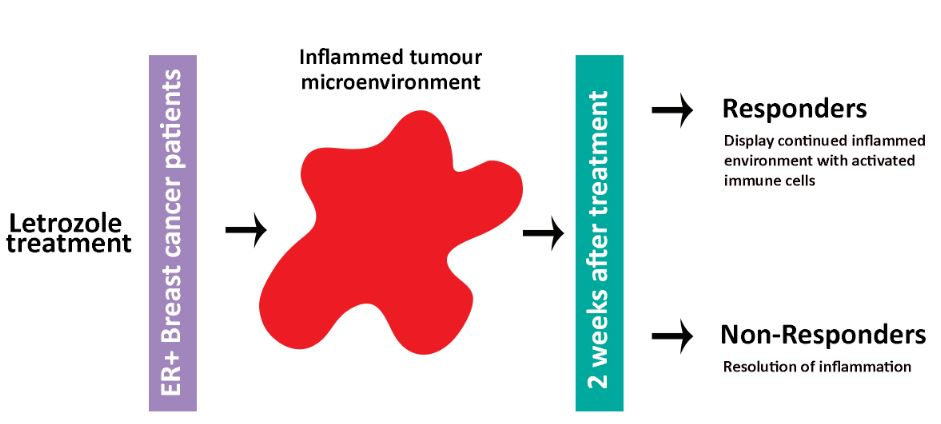

In [100]:
Image("//ris-fas1a.roslin.ed.ac.uk/v1anirma/Win7/Desktop/Anastrazole/img/proposed model.JPG")

### Import packages

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Image

### Import data
The immune signature was defined by a manual feature selection of the most co-expressed genes (ImSig), identified from the network graph. <br/>
The 'neighbour' set of genes were identified by performing a node-walk around the macrophages and T cell feature selected genes in Miru

In [3]:
# Set Working directory
#WD = '//ris-fas1a.roslin.ed.ac.uk/v1anirma/Win7/Desktop/Anastrazole'
WD = '/Users/Ajit/Dropbox/Anastrazole/'
os.chdir(WD)
# Import data
exp = pd.read_csv('pre_collapse.txt', delimiter='\t', index_col=0)
sig = pd.read_csv('feature selected genes.txt', delimiter='\t', index_col=0)
response = pd.read_csv('response.txt', delimiter='\t', index_col=0)
neighbour = pd.read_csv('neighbour.txt', delimiter='\t', index_col=0)

### Reduce multiple transcripts into one gene

In [4]:
grouped = exp.groupby(exp.index).max()
grouped = grouped.apply(lambda x: np.power(x,2), axis=1)
# Write out the collapsed DataFrame if necessary
# grouped.to_csv('Post Collapse.txt', sep= "\t")

# <span style="color:Red">Step-1: Calculate the abundance of immune cells</span>
The objective is to test if there is a change in the number of immune cells between the responders and non-responders. 

In [4]:
# Subset exp for sig genes
exp_sig = grouped.merge(sig, how='inner',  left_index=True, right_index=True).sort_values(['ImSig'])
# Calculate average expression of sig genes for each sample
exp_sig_mean = exp_sig.set_index('ImSig')
exp_sig_mean = exp_sig_mean.groupby(exp_sig_mean.index).mean()
# Create the DataFrame that will be used for generating the figure
exp_plot = exp_sig_mean.transpose()

Split the dataset into two parts so that the responders and non-responders can be vizualised seperately

In [5]:
exp_plot = exp_plot.join(response)
responder = exp_plot[exp_plot['response'] == "responder"]
nonresponder = exp_plot[exp_plot['response'] == "non-responder"]

In [6]:
# Melt the data for vizulalisation
exp_plot_melt_r = pd.melt(responder, id_vars=['group'], value_vars= ['B cells','Cell Cycle', 'IFN', 'Macrophages', 'T cells'])
exp_plot_melt_nr = pd.melt(nonresponder, id_vars=['group'], value_vars= ['B cells','Cell Cycle', 'IFN', 'Macrophages', 'T cells'])

### Peforming a paired-t-test (before vs after treatment)

In [7]:
# Caluculating the p-value for non-responders
p_value_nr = pd.DataFrame()
nr_p = nonresponder.set_index('group').drop('response', axis=1)
for i in list(nr_p):
    cell = nr_p[[i]]
    bt = cell[cell.index == 'Before Treatment']
    at = cell[cell.index == 'After Treatment']
    bt = bt[i].tolist()
    at = at[i].tolist()
    paired_sample = stats.ttest_rel(bt, at)
    p = paired_sample.pvalue
    p ={i:[p]}
    p = pd.DataFrame(data = p).transpose()
    p_value_nr  = p_value_nr.append(p)
# Print output
p_value_nr.columns = ['Non-Responders p-value']
p_value_nr

,Non-Responders p-value
B cells,0.569306
Cell Cycle,0.000815
IFN,0.983762
Macrophages,0.365260
T cells,0.495288


In [8]:
# Caluculating the p-value for responders
p_value_r = pd.DataFrame()
r_p = responder.set_index('group').drop('response', axis=1)
for i in list(r_p):
    cell = nr_p[[i]]
    bt = cell[cell.index == 'Before Treatment']
    at = cell[cell.index == 'After Treatment']
    bt = bt[i].tolist()
    at = at[i].tolist()
    paired_sample = stats.ttest_rel(bt, at)
    p = paired_sample.pvalue
    p ={i:[p]}
    p = pd.DataFrame(data = p).transpose()
    p_value_r = p_value_r.append(p)
# Print output
p_value_r.columns = ['Responders p-value']
p_value_r

,Responders p-value
B cells,0.569306
Cell Cycle,0.000815
IFN,0.983762
Macrophages,0.365260
T cells,0.495288


### Plot the results

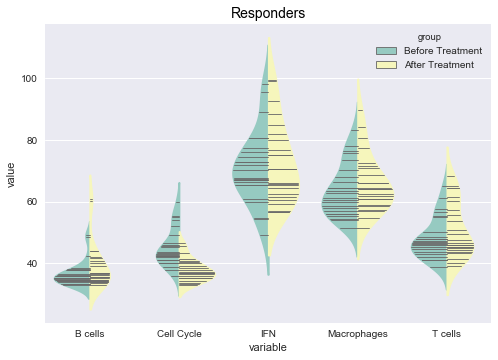

In [9]:
# Plotting Responders
g =sns.violinplot(x="variable", y="value", hue="group", split=True, inner = 'stick', data=exp_plot_melt_r, palette="Set3")
g.axes.set_title('Responders', fontsize=14, color="black")
plt.show()

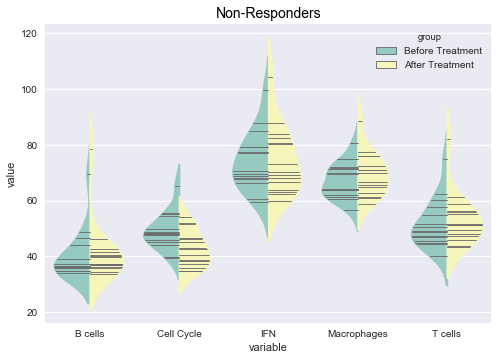

In [10]:
# Plotting Non-Responders
g =sns.violinplot(x="variable", y="value", hue="group", split=True, inner = 'stick', data=exp_plot_melt_nr, palette="Set3")
g.axes.set_title('Non-Responders', fontsize=14, color="black")
plt.show()

# <span style="color:Red">Interpretation of above results</span>
As it can be seen that there is a change in the number of macrophages and T cells in responders compared to non-responders. A significant decrease in proliferation is observable in both responders and non-responders.


# -----------------------------------------------------------------------------------------

# <span style="color:Red">Step-2: Identifying the differentiation state of the immune environment</span>
It is possible that the macrophages are in two different states of activation in responders and non-responders. The following ananlysis is to identify if such a state exits.

### Function to calculate the correlation of given set of genes to a single gene

In [5]:
def genecorr(GOI):
    # Split data into before and after treatment
    data = grouped.transpose()
    data = data.join(response, how='inner')
    data_bt = data[data['group'] == 'Before Treatment']
    data_at = data[data['group'] == 'After Treatment']
    # Split the data into responders and non-responders within before and after treatment groups
    d_bt_r = data_bt[data_bt['response'] == 'responder'].drop(['response', 'group'], axis=1, inplace=False)
    d_bt_nr = data_bt[data_bt['response'] == 'non-responder'].drop(['response', 'group'], axis=1, inplace=False)
    d_at_r = data_at[data_at['response'] == 'responder'].drop(['response', 'group'], axis=1, inplace=False)
    d_at_nr = data_at[data_at['response'] == 'non-responder'].drop(['response', 'group'], axis=1, inplace=False)
    # Calculate correlation matrix
    d_bt_r_cor = d_bt_r[d_bt_r.columns[1:]].corr()[GOI][:-1]
    d_bt_nr_cor = d_bt_nr[d_bt_nr.columns[1:]].corr()[GOI][:-1]
    d_at_r_cor = d_at_r[d_at_r.columns[1:]].corr()[GOI][:-1]
    d_at_nr_cor = d_at_nr[d_at_nr.columns[1:]].corr()[GOI][:-1]
    # Create the dataframe for plotting
    # First comparision: BEFORE TREATMENT- responders vs non-responders
    bt_p = pd.concat([d_bt_r_cor, d_bt_nr_cor], axis=1, join='inner')
    bt_p.columns = range(bt_p.shape[1])
    bt_p = bt_p.join(neighbour, how = 'inner').rename(columns = {0:'Responders', 1: 'Non-Responders'})
    # Second comparision: AFTER TREATMENT- responders vs non-responders
    at_p = pd.concat([d_at_r_cor, d_at_nr_cor], axis=1, join='inner')
    at_p.columns = range(at_p.shape[1])
    at_p = at_p.join(neighbour, how = 'inner').rename(columns = {0:'Responders', 1: 'Non-Responders'})
    # Pre processing to plot the results
    # Join the two dataFrames to plot them side by side
    at_p['vars'] = ['After Treatment']*len(at_p)
    bt_p['vars'] = ['Before Treatment']*len(bt_p)
    frames = [bt_p, at_p]
    plot = pd.concat(frames, join = 'outer')
    #plot = at_p.append(bt_p)
    return {'plot':plot, 'after treatment':at_p, 'before treatment':bt_p}

## Function to isolate genes of interest

In [6]:
# Function for genes of interest in responders
def GOIR(res, nonres, data):
    # Subset genes based on two conditions
    set1 = data[data['vars'] == 'After Treatment']
    set1 = set1[(set1['Responders'] >= res)]
    set1 = set1[(set1['Non-Responders'] <= nonres)]
    set1['selected genes'] = ['selected genes']*len(set1)
    set1 = set1[['selected genes']]
    # Plotting the genes
    plot_1  = set1.join(data, how='outer')
    plot_1  = plot_1.fillna(value= 'Rest')
    return {'plot':plot_1, 'selected_genes':set1}

# Function for genes of interest in non-responders
def GOINR(res, nonres, data):
    # Subset genes based on two conditions
    set2 = data[data['vars'] == 'After Treatment']
    set2 = set2[(set2['Responders'] <= res)]
    set2 = set2[(set2['Non-Responders'] >= nonres)]
    set2['selected genes'] = ['selected genes']*len(set2)
    set2 = set2[['selected genes']]
    # Plotting the genes
    plot_2  = set2.join(data, how='outer')
    plot_2  = plot_2.fillna(value= 'Rest')
    return {'plot':plot_2, 'selected_genes':set2}

# <span style="color:Red">Studying changes in Macrophages using CD163</span>

The below plot shows how immune related genes are correlated with macrophages before and after treatment in responders vs non-responders. *CD68* was not available in the dataset.


In [7]:
cd163 = genecorr('CD163')

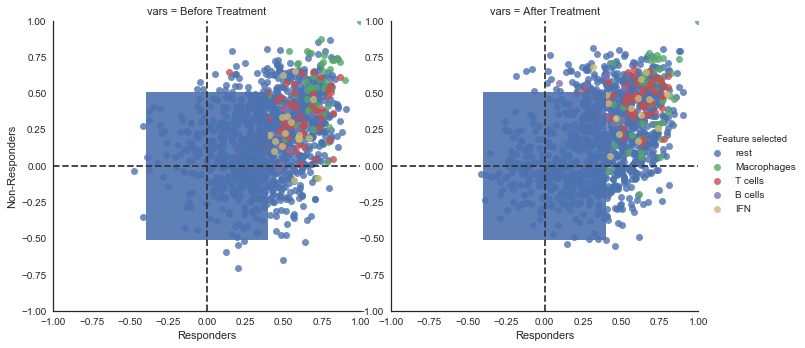

In [8]:
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data= cd163['plot'], x='Responders', y='Non-Responders', col='vars', hue='Feature selected', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
    x = [-0.4,0.4,0.4,-0.4]
    y = [0.51,0.51,-0.51,-0.51]
    ax.fill(x,y, facecolor='b', alpha=0.9)
lm.set(xlim=(-1, 1), ylim=(-1, 1));
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

## <span style="color:Red">Interpretation of above results</span>

No striking difference can be seen before and after treatment but the macrophage and T cell realted genes seem to be slightly more correlated after treatment. No obvious difference can be observed between responders and non-responders. However, we are now only looking at the core genes. It is possible that macrophages have differential function between responders and non-responders. This can be checked by identifying <br>
**a)** Genes that are well correlated (r > 0.7)in responders but poorly correlated (r < 0.3) in non-responders<br>
**b)** Genes that are correlated in non-responders and poorly correlated in responders

### Identifying genes that are  correlated (r > 0.7) in responders but poorly correlated (r < 0.3) in non-responders

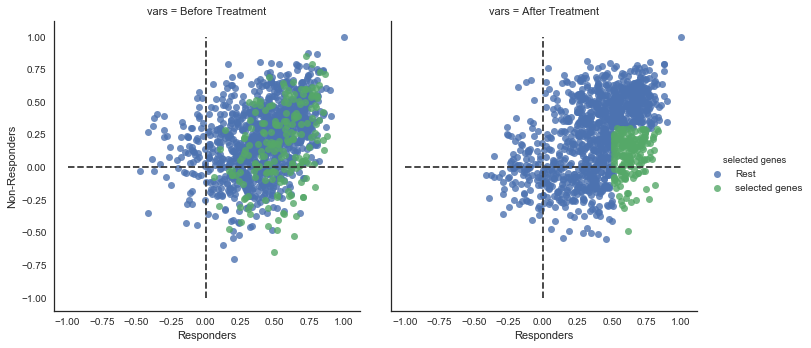

In [16]:
# Look at genes that are unique in responders
cd163r = GOIR(0.51,0.30,cd163['plot'])
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data= cd163r['plot'], x='Responders', y='Non-Responders', col='vars', hue='selected genes', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

## <span style="color:Red">Interpretation of above results</span>

As it can be seen from the above figure that, the genes that are correlated in responders are not corelated in non-responders. 

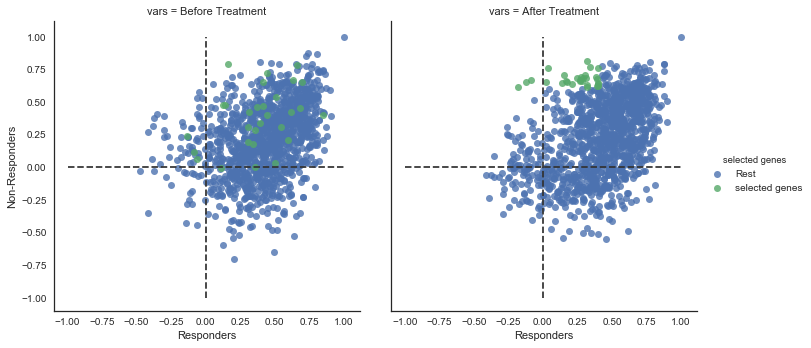

In [13]:
# Look at genes that are unique in non-responders
cd163nr = GOINR(0.40,0.6, cd163['plot'])
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data=cd163nr['plot'], x='Responders', y='Non-Responders', col='vars', hue='selected genes', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

# ---------------------------------------------------------------------------- 
# ------------------------ OTHER ANALYSIS ------------------------ 
# ---------------------------------------------------------------------------- 

# Studying changes in T cells using CD3G
The below plot shows how immune related genes are correlated with CD3G before and after treatment in responders vs non-responders. The colured area is non-significant.

In [6]:
plot = genecorr('CD3G')

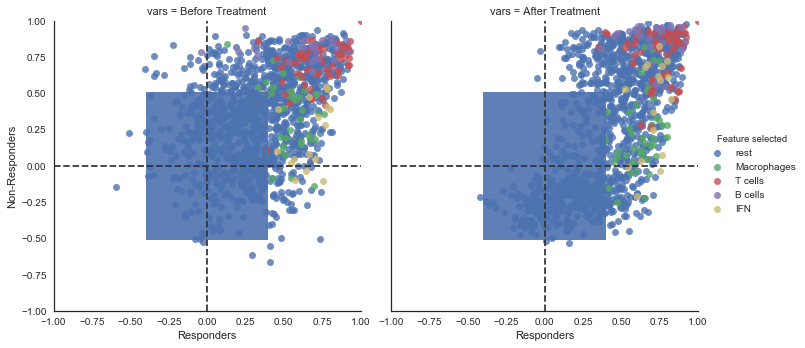

In [7]:
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data= plot['plot'], x='Responders', y='Non-Responders', col='vars', hue='Feature selected', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
    # Correlation significance areas
    #ax.axvspan(-1, -0.4, facecolor='b', alpha=0.2)
    #ax.axhspan(-1, -0.51, facecolor='b', alpha=0.2)
    x = [-0.4,0.4,0.4,-0.4]
    y = [0.51,0.51,-0.51,-0.51]
    ax.fill(x,y, facecolor='b', alpha=0.9)  
lm.set(xlim=(-1, 1), ylim=(-1, 1));
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

It can be seen from the above plot that T cell related genes are well correlated in both responders and non-responders and in both the time points. However, a change in macrophage realted genes can be observed after treatment. It might be interesting to study the genes that are highly correlated in responders but are poorly (r < 0.3) or negatively correlated in non-responders (After treatment).

### Isolating the genes of interest

In [13]:
cd3r = GOIR(0.51,0.30,plot['plot'])

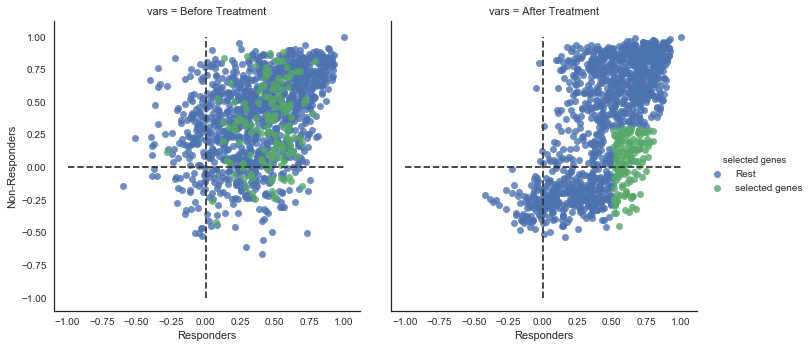

In [14]:
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data=cd3r['plot'], x='Responders', y='Non-Responders', col='vars', hue='selected genes', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

In [297]:
# Write out the selected genes
cd3r['selected_genes'].to_csv('cd3-resonders.csv')

Interpretation: <br/>
a) Treatment has instigated a set of functions (i.e. genes less correlated before treatment become correlated after treatment) <br/>
b) Responders preferential function. (i.e. genes that are less correlated in non-responders are correlated in responders.

### Calculate the median correlation of the highlighted genes

In [16]:
# Average correltation of the gene set before and after treatment
ac = cd3r['selected_genes'].join(grouped).drop('selected genes', axis=1).transpose()
ac = ac.join(response, how='inner').drop('response', axis=1)
bt_ac = ac[ac['group'] == 'Before Treatment']
at_ac = ac[ac['group'] == 'After Treatment']
#Calculate correlation
bt_ac = bt_ac.corr(method='pearson')
at_ac = at_ac.corr(method='pearson')
# Keep only upper triangle
bt_keep = np.triu(np.ones(bt_ac.shape)).astype('bool').reshape(bt_ac.size)
bt_keep = pd.DataFrame(bt_ac.stack()[bt_keep])
at_keep = np.triu(np.ones(at_ac.shape)).astype('bool').reshape(at_ac.size)
at_keep = pd.DataFrame(at_ac.stack()[at_keep])

#### The median correlation of the higlighted set of genes After Treatment is:
The low correlation value is due to the inclusion of negative values

In [18]:
at_keep[0].median()

0.5497639073385642

It can be seen from the above plot that the highlighted set of genes, that are co-expressed after treatment (and apparent only in responders) are not co-expressed before treatment. It could be speculated that the fuction of this set of genes become apparent only after treatment and only in responders. An enrichment analysis might be able to point us towards the function of this set of genes.

### Enrichment analysis of the highlighted genes

Enrichment analysis  performed at http://amp.pharm.mssm.edu/Enrichr/enrich

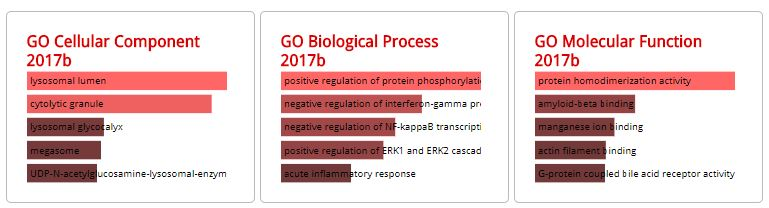

In [142]:
Image("//ris-fas1a.roslin.ed.ac.uk/v1anirma/Win7/Desktop/Anastrazole/img/enrichr-cd3.JPG")

Enrichment analysis performed at https://toppgene.cchmc.org/

### Analysis of IFNG

In [9]:
CD54 = genecorr('GPR32')

In [7]:
**Genes of interest** <br>
anti-apoptotic protein: BCL2, BIRC3 <br>
pro-apoptotic proteins: BAK, BIK & caspase 9 <br>
Cell cycle related: AP1, STAT3, HER2, ki67, cyclin D and E <br>
Estrogen receptor: ESR1 <br>
TNFα, produced by macrophages, led to activation of NFκB and JNK pathways <br>
IL1, PR <br>
epigenetic control including: NCOR1, NCOR2, SRC1, and AIB1 <br>
autophagocytosis: HSBP8 <br>


SyntaxError: invalid syntax (<ipython-input-7-376df31e15f3>, line 1)

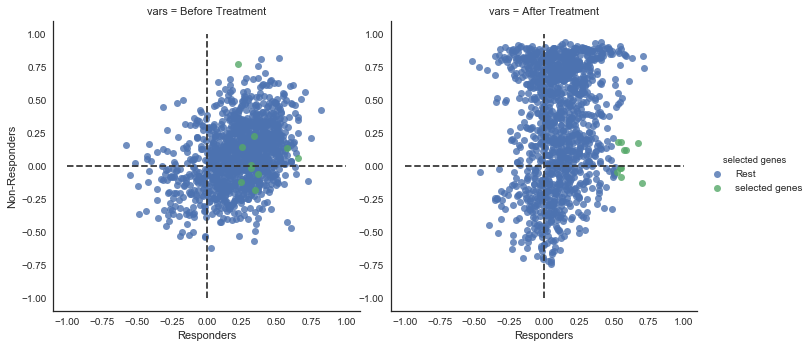

In [10]:
# Identifying responders genes
ifngr = GOIR(0.51,0.30,CD54['plot'])
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data= ifngr['plot'], x='Responders', y='Non-Responders', col='vars', hue='selected genes', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

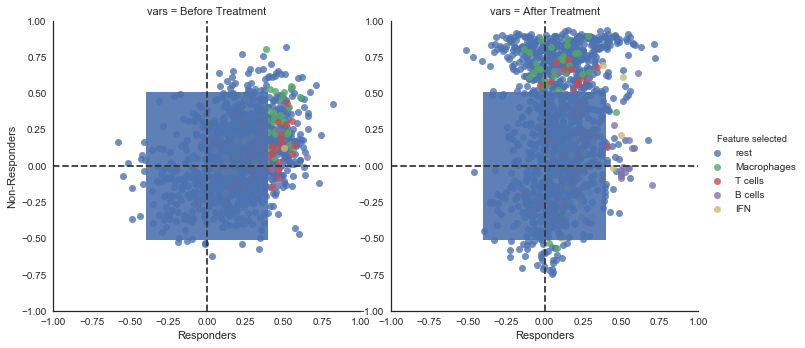

In [11]:
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data= CD54['plot'], x='Responders', y='Non-Responders', col='vars', hue='Feature selected', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
    # Correlation significance areas
    #ax.axvspan(-1, -0.4, facecolor='b', alpha=0.2)
    #ax.axhspan(-1, -0.51, facecolor='b', alpha=0.2)
    x = [-0.4,0.4,0.4,-0.4]
    y = [0.51,0.51,-0.51,-0.51]
    ax.fill(x,y, facecolor='b', alpha=0.9)  
lm.set(xlim=(-1, 1), ylim=(-1, 1));
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

In [60]:
# Write out the selected genes
ifngr['selected_genes'].to_csv('TSC22D3-resonders.csv')

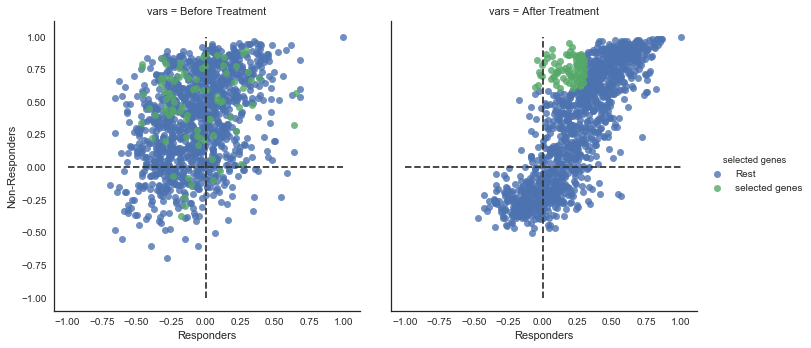

In [32]:
# Look at genes that are unique in non-responders
ifngnr = GOINR(0.30,0.6, CD54['plot'])
sns.set(style="white", color_codes=True)
lm = sns.lmplot(data=ifngnr['plot'], x='Responders', y='Non-Responders', col='vars', hue='selected genes', fit_reg=False)
for ax in lm.axes.flat:
    ax.plot((-1, 1), (0, 0), c=".2", ls="--")
    ax.plot((0, 0), (-1, 1), c=".2", ls="--")
lm.fig.subplots_adjust(wspace=.1, hspace=2);
plt.show()

In [34]:
# Write out the selected genes
ifngnr['selected_genes'].to_csv('CXCR2-non-resonders.csv')

anti:GPR32, FOXP3, ANPEP, POMC
inflammatory: TNF
https://www.ncbi.nlm.nih.gov/pubmed/22449948